# Lecture 3.3: Bayesian A/B Testing  

## The Boss's Complaint

You've now been running A/B tests, evaluating them, and making useful business decisions for months. You're confident that you're actually making correct decisions. Life seems good. But then in a meeting:

Your boss asks, *"So when can we wrap up that button test?"*

*"It doesn't look like it will stop any time soon,"* you reply.

*"I know,"* says your boss, *"we've been running it for three months, it has over 10k conversions. We have other ideas to try, we need to kill that test."*

*"But,"* you say, *"it is nowhere near significance. Stopping it is completely wrong under the procedure we're using, we'll have no idea whether we're making the right decision!"*

Your boss snaps, "*Doing 'the right decision' could easily take a million more conversions! If we knew how to get to a million conversions, we'd all be rich and wouldn't care about the color of the button! We'll declare the red button the winner, and you need to figure out a better way to stop the next test."*

Clearly your boss has a point. Businesses need to be able to make decisions, and have a limited ability to collect data. But how can we say that in math? And what are the consequences if we do?

Why are hypothesis tests under fire?  There are many reasons, and a crucial one is that hypothesis tests and p-values are hard to understand and hard to explain.  There are arbitrary thresholds (0.05?) and the results are binary - you can either reject the null hypothesis or fail to reject the null hypothesis.  And is that what you really care about? Which of these two statements is more appealing:

(1) "We rejected the null hypothesis that A = B with a p-value of 0.043."

(2) "There is an 85% chance that A has a 5% lift over B ."

Bayesian modeling can answer questions like (2) directly.

## Frequentist vs Bayesian  

**Frequentist**:  

* Data are a repeatable random sample
* Underlying parameters remain constant during this repeatable process
* Parameters are fixed

**Bayesian**:  

* Data are observed from the realized sample
* Parameters are unknown and described probabilistically
* Data are fixed

**Example**:
* In frequentist statistics
    * $\mu$ is fixed and unknown
    * $\bar{X}$ is a random variable
* In Bayesian statistics
    * $\mu$ is a random variable
    * $\bar{X}$ is observed and fixed

## Frequentist A/B Testing  

* The sample size needs to be fixed in advance
* Point estimates and standard errors or 95% confidence intervals 
* Deduction from $P(data\ | \ H_0)$, by setting $\alpha$ in advance 
* Reject $H_0$ if $P(data \ | \ H_0) < \alpha$

## Bayesian A/B Testing  

* Induction from $P(\theta \ | \ data)$, starting with $P(\theta)$  

### Bayes Theorem  

$$ P(\theta \ | \ x) = \frac{P(x \ | \ \theta) P(\theta)}{P(x)} $$

* $P(\theta)$: **prior**, initial belief  
* $P(x \ | \ \theta)$: **likelihood** of data  
* $P(\theta \ | \ x)$: **posterior**, updated belief
* $P(x)$: normalizing constant

$$ \text{posterior} \propto \text{prior} \times \text{likelihood} $$

**Example**: We want to estimate the click-through rate (CTR) of a a website, where  

$$ p = CTR = \frac{\text{# clicks}}{\text{# pageviews}} $$  

* If we observe 536 clicks over 887 page views, what is the likelihood $P(x \ | \ p)$?  


* If we let $p \sim Beta(1, 1)$ be the prior, what would the posterior distribution $P(p \ | \ x)$ look like?

$X \sim Binomial(887, p)$, so

$$ P(x \ | \ p) = \binom{887}{536} p^{536} (1 - p)^{(887 - 536)} \ \propto \ p^{536} (1 - p)^{351}$$

In [9]:
# We can obtain the posterior distribution
# by multiplying the prior and the likelihood

posterior = function(a, b, p, x, n) {
    dbeta(p, a, b) * dbinom(x, n, p)
}

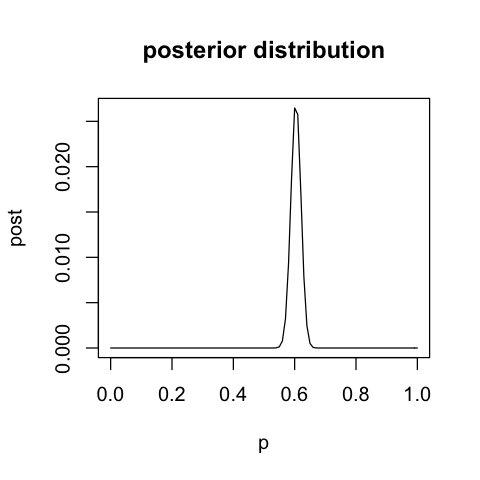

In [14]:
a = 1
b = 1
x = 536
n = 887

p = seq(0, 1, 0.01)
post = posterior(a, b, p, x, n)
options(repr.plot.width = 4, repr.plot.height = 4)
plot(p, post, type = "l", main = "posterior distribution")

* How can we obtain point and interval estimate of p?

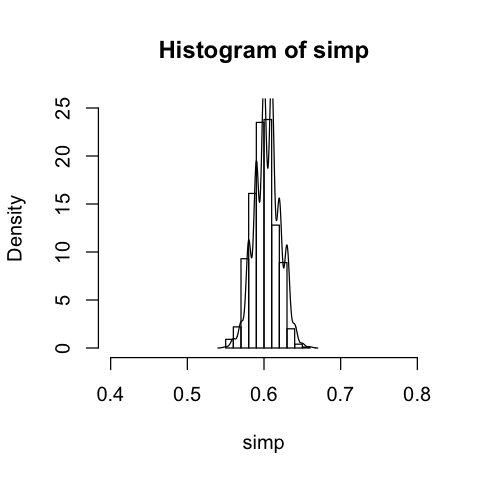

In [31]:
simp = sample(p, 1000, replace = T, prob = post)
hist(simp, freq = F, xlim = c(0.4, 0.8), ylim = c(0, 25))
lines(density(simp))

In [32]:
# point estimate
mean(simp)

[1] 0.60417

In [45]:
# interval estimate
sort(simp)[c(25, 975)]

[1] 0.57 0.63

### Conjugate Prior  

* There's something quite nice about the set up of the previous example
* A Beta prior has the following PDF:  

$$ P(p) = \frac{p^{\alpha - 1} (1 - p)^{\beta - 1}}{B(\alpha, \beta)} $$  

* A Binomial random variable has the following PDF:  

$$ P(x \ | \ p) = \binom{n}{x} p^x (1 - p)^{n - x} $$  

* If we multiply them, we get a Beta distribution again:  

$$ 
\begin{align*} 
\text{posterior} &\propto \text{prior } \times \text{likelihood}   \\ 
&=  \frac{p^{\alpha - 1} (1 - p)^{\beta - 1}}{B(\alpha, \beta)} \times \binom{n}{x} p^x (1 - p)^{n - x} \\
&\propto p^{\alpha - 1} (1 - p)^{\beta - 1} \times p^x (1 - p)^{n - x} \\
&\propto p^{\alpha + x - 1} (1 - p)^{\beta + n - x - 1}
\end{align*} $$

$\Rightarrow \text{posterior } \sim Beta(\alpha + x, \beta + n - x) $  

* When the prior and the posterior belong to the same distribution family, the prior is called the [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) for the likelihood function, e.g. the Beta distribution is a conjugate prior for the Binomial distribution. 

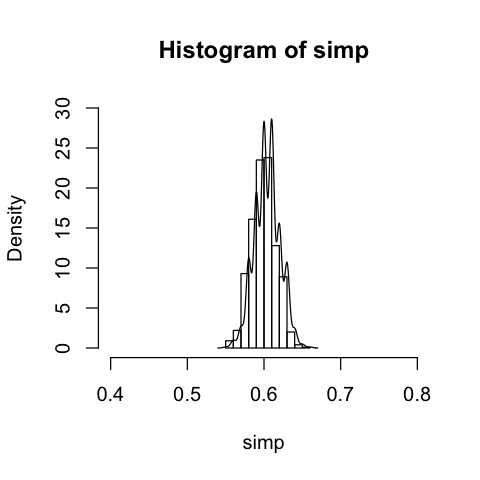

In [40]:
# To obtain the estimates for the previous example
# We can directly simulate data from the known Beta distribution

simp2 = rbeta(1000, 1 + x, 1 + n - x)
hist(simp, freq = F, xlim = c(0.4, 0.8), ylim = c(0, 30))
lines(density(simp))

In [41]:
# point estimate
mean(simp2)

[1] 0.6035283

In [46]:
# interval estimate
sort(simp2)[c(25, 975)]

[1] 0.5727540 0.6345273

### Credible Interval  

* The interval estimate we obtain based on the posterior distribution is called the **credible interval**
* Unlike the frequentist confidence interval, we can interpret the credible interval in terms of probability
* There is a 95% probability/chance that p is between 0.57 and 0.63

In [47]:
# We can also obtain the estimates analytically
# point estimate
(1 + x)/(2 + n)

[1] 0.6040495

In [49]:
# interval estimate
qbeta(c(0.025, 0.975), 1 + x, 1 + n - x)

[1] 0.5717060 0.6359495

### Why Bayesian A/B Testing?

There are three major advantages the Bayesian A/B test has over the frequentist method.

1. It’s far easier to interpret the results. For example, you can easily compute the probability that version B is better than version A. In contrast, a frequentist test does not allow this even as a possibility.

2. You can peek as often as you like. The Bayesian test is measuring the probability at time $t$ that B is better than A (or vice versa). You can look at the data, check if the test is finished, and stop the test early if the result is highly conclusive. This philosophical advantage is also an empirical, business advantage when dealing with the reality that timing a test is often at odds with the reality that in a standard test, your results may come after a point where you ABSOULTELY NEED to make a decision.

3. You can alter your test material in the middle of the test. If you believe your test is not going anywhere, you can use your current posteriors as new priors for what is essentially the start of a new test without any major interruptions in your development flow. Standard tests do not allow for this because of the “no peeking” problem. This means a bayesian approach is extremely useful to anyone involved in either Agile Development or Agile Marketing, since the testing schedule can be made to work with your development lifecycle.  

**Example**: Let's think this through with an example. Assume your parameter of interest is click-through rate (CTR), and your A/B test is putting two different product recommendation engines against one another. With frequentist hypothesis testing, you assume that there exist true-but-unknown click-through rates for A and B, which we will write as $p_A$ and $p_B$, and the goal is to figure out if they are different or not.

With Bayesian statistics we we will instead model the $p_A$ and $p_B$ as random variables, and specify their entire distributions. $p_A$ and $p_B$ are no longer two numbers, but are now two distributions.

So forget everything you know about statistical testing for now. Let's start from scratch and answer our customer's most important question directly: what is the probability that $p_A$ is larger than $p_B$ given the data from the experiment (i.e. a sequence of 0s and 1s in the case of click-through-rate)? 

* Set the priors for $p_A$ and $p_B$ to be Beta(1, 1)
* We observe 563 clicks out of 835 views with version A, and  463 clicks out of 829 views with version B
* We can compare the posterior distributions $P(p_A \ | \ data)$ and $P(p_B \ | \ data)$   

**Q**: What are the posterior distributions for $p_A$ and $p_B$?  

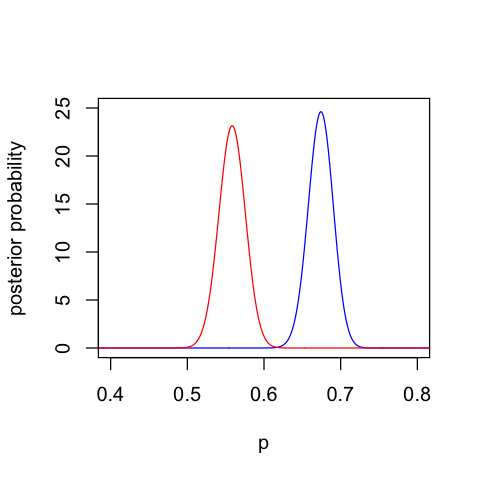

In [62]:
p = seq(0, 1, 0.001)
post_a = dbeta(p , 1 + 563, 1 + 835 - 563)
post_b = dbeta(p , 1 + 463, 1 + 829 - 463)
plot(p, post_a, type = "l", col = "blue", xlim = c(0.4, 0.8), ylim = c(0, 25), ylab = "posterior probability")
lines(p, post_b, col = "red")

### Comparing Two Distributions

* What we're trying to do is to determine the probability that site A is better than site B. We can get the posterior distributions (beta distributions) for both site A and site B based on our prior and observation data.

* We do this calculation by simulating a large number (let's say 10,000) draws from both distributions. We count the number of times A was higher than B. This is the number of times out of 10,000 that A was better than B, so we get a probability that A is better than B.
    
* We can also answer if this is true: conversion rate of site A > conversion rate of site B + 5%  

**Exercise**:  

* Find $P(p_A > p_B)$ and $P(p_A > p_B + 0.1)$
* Give a 95% credible interval for the difference between $p_A$ and $p_B$